In [ ]:
import pandas as pd
import numpy as np

REDWINE_PATH = "../datasets/winequality-red.csv"
WHITEWINE_PATH = "../datasets/winequality-white.csv"

# read red wine set of observations
data_red = pd.read_csv(REDWINE_PATH,sep=',')
data_red['color'] = 1 #redwine

print(data_red.shape)

# read white wine set of observations
data_white = pd.read_csv(WHITEWINE_PATH,sep=',')
data_white['color'] = 0 #whitewine

print(data_white.shape)

# merge the two sets in one
data = data_red.merge(data_white, how='outer')
fields = list(data.columns)
print(fields)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# show the histograms of values per feature (eg most of whines are at about 8 proof strength)
sns.set()
data.hist(figsize=(10,10),color='red', bins=13)
plt.show()

In [ ]:
# show the historgram of wine rankings (quality between 1 and 10)
data['quality'].hist(color='red', bins=13)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

data_red = pd.read_csv(REDWINE_PATH,sep=',')
data_red['color'] = 1 #redwine

print(data_red.shape)

data_white = pd.read_csv(WHITEWINE_PATH,sep=',')
data_white['color'] = 0 #whitewine

print(data_white.shape)

data = data_red.merge(data_white, how='outer')


# based on the "quality histograms" above, we will drop the ratings with low counts (we will keep only 3 dimesnions = 5,6,7)
data = data.drop(data[data.quality == 1].index)    # not recorded anyway
data = data.drop(data[data.quality == 2].index)    # not recorded anyway
data = data.drop(data[data.quality == 10].index)   # not recorded anyway
data = data.drop(data[data.quality == 9].index)
data = data.drop(data[data.quality == 3].index)
data = data.drop(data[data.quality == 8].index)
data = data.drop(data[data.quality == 4].index)

In [ ]:
data.quality.value_counts()

In [20]:
fields = list(data.columns)
print(fields)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']


In [21]:
# split the data set in two: 1) color+features (observations)  2) quality (actuals)

fields = list(data.columns[:-2])
fields.append('color')  #adding color back
X = data[fields]
y = data['quality']
print(fields)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']


A Pearson correlation was used to identify which features correlate with wine quality. It looks as if higher the alcohol content the higher the quality. Lower density and volatile acidity also correlated with better quality as seen in the pairwise correlation chart the chart below. Only the top 5 correlated features were carried over to the KNN models.

In [22]:
correlations = data[fields].corrwith(y)
correlations.sort_values(inplace=True)

# the following fields are the 5 retained as having the highest correlations to wine quality
fields = correlations.map(abs).sort_values().iloc[-5:].index
print(fields) #prints the top two abs correlations

Index(['color', 'chlorides', 'volatile acidity', 'density', 'alcohol'], dtype='object')


[(-1.0, 1.0), Text(0, 0.5, 'pearson correlation')]

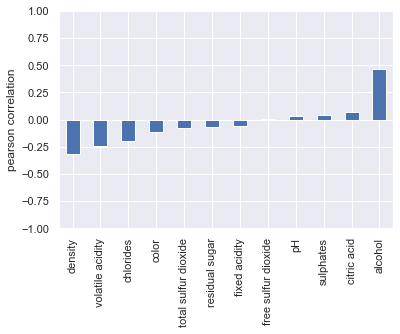

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# The figure below shows Pearson Pairwise correlation of features to wine quality.
# Looks like alcohol and density are the most correlated with quality
ax = correlations.plot(kind='bar')
ax.set(ylim=[-1, 1], ylabel='pearson correlation')

In [24]:

USE_MINMAXSCALER = False

X = data[fields]
if USE_MINMAXSCALER:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
else:
    # Alternative to previous scalar
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # Fit on training set only.
    X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=['%s_scaled' % fld for fld in fields])
print(X.columns) #scaled columns

Index(['color_scaled', 'chlorides_scaled', 'volatile acidity_scaled',
       'density_scaled', 'alcohol_scaled'],
      dtype='object')


We will now run Logistic Regression algorithm to create a "prediction model"

Since the data captured is in different magnitude ranges, it is generally a good idea to scale so one feature doesn’t get more influence than the other (in terms of scale).

In [25]:
from sklearn.model_selection import train_test_split

# test_size: what proportion of original data is used for test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7.0, random_state=122)

In [26]:
from sklearn.linear_model import LogisticRegression
import time

MYSOLVER = "lbfgs" #"newton-cg"

startproc = time.time()

logreg = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver=MYSOLVER,
          tol=0.0001, verbose=0, warm_start=False)

# fit the model with training data
logreg.fit(X_train, y_train)

# predict the wine rankings for the test data set
y_pred = logreg.predict(X_test)

proctime = time.time() - startproc

print(y_pred,X_test)


[6 5 6 5 5 6 5 6 5 6 7 5 6 5 7 6 6 5 5 6 6 6 5 6 5 6 6 5 5 6 6 6 5 7 5 6 6
 6 5 6 6 6 5 6 6 6 5 6 5 5 6 6 6 5 5 5 6 6 7 6 6 6 6 5 5 6 6 6 6 6 5 6 6 6
 5 6 6 5 7 5 6 6 6 6 6 6 6 5 5 5 7 6 5 6 6 5 6 5 6 6 5 6 5 6 6 6 6 6 5 5 6
 6 5 5 5 5 5 5 5 6 6 6 7 5 5 6 6 5 6 6 6 6 6 6 6 5 5 6 5 6 5 6 7 5 6 6 6 6
 5 6 5 6 6 6 6 6 6 6 5 6 6 6 6 6 5 6 7 7 6 6 6 5 6 7 6 6 6 6 6 6 6 6 6 6 7
 6 6 6 5 5 6 7 6 6 6 6 6 5 6 6 6 6 7 5 6 6 6 7 6 6 6 5 6 6 6 6 6 6 5 6 6 6
 5 6 6 6 6 6 5 5 5 6 6 6 5 6 6 5 6 6 7 6 6 5 6 5 6 6 6 6 5 5 5 6 5 6 6 6 6
 6 6 5 5 6 6 5 6 6 6 5 5 5 5 6 5 6 5 7 5 6 5 7 6 6 5 5 5 6 5 6 6 5 6 6 7 5
 6 6 7 6 6 5 7 6 6 6 5 6 6 6 6 6 7 5 6 6 6 6 6 5 7 5 5 6 6 7 5 5 5 5 6 6 5
 6 5 6 6 6 6 5 6 6 6 6 5 5 5 6 6 5 6 6 6 6 6 5 5 5 6 5 6 6 6 5 5 5 5 6 6 6
 6 5 5 6 6 5 7 5 5 6 6 5 6 6 6 6 5 6 5 5 5 6 6 6 6 6 5 6 5 5 6 6 5 6 5 7 5
 5 6 6 6 6 6 5 6 5 5 7 6 5 6 6 6 5 6 5 6 6 6 6 6 5 5 6 6 5 5 5 6 7 6 6 6 6
 5 5 7 6 6 6 6 6 7 5 6 6 5 6 6 6 6 6 6 6 5 5 6 6 7 6 6 6 5 5 5 6 6 6 5 6 6
 5 6 7 5 6 6 6 6 5 6 5 6 

In [28]:
from sklearn.metrics import accuracy_score

# how did our model perform?
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 388
Accuracy: 0.55


### About Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") 
on a set of test data for which the true values are known.

Here is a set of the most basic terms, which are whole numbers (not rates):
1. true positives (TP): These are cases in which we predicted "yes" where it is actually "yes".
2. true negatives (TN): We predicted no, and it is actually "no".
3. false positives (FP): We predicted "yes", and was actually "no" (Also known as a "Type I error."
4. false negatives (FN): We predicted "no", and was actually "yes". (Also known as a "Type II error.")
    
This is a list of rates that are often computed from a confusion matrix for a binary classifier:

**Accuracy**: Overall, how often is the classifier correct? 
    <br>&emsp;accuracy = (TP+TN)/total

**Misclassification Rate**: Overall, how often is it wrong? 
    <br>&emsp;misrate = (FP+FN)/total
    <br>&emsp;equivalent to 1 minus Accuracy
    <br>&emsp;also known as "Error Rate"

**True Positive Rate**: When it's actually yes, how often does it predict yes? 
    <br>&emsp;tprate = TP/actual_yes
    <br>&emsp;also known as "Sensitivity" or "Recall"

**False Positive Rate**: When it's actually no, how often does it predict yes?
    <br>&emsp;fprate = FP/actual_no

**True Negative Rate**: When it's actually no, how often does it predict no? 
    <br>&emsp;tnrate = TN/actual_no
    <br>&emsp;equivalent to 1 minus False Positive Rate
    <br>&emsp;also known as "Specificity"

**Precision**: When it predicts yes, how often is it correct? 
    <br>&emsp;precision = TP/predicted_yes

**Prevalence**: How often does the yes condition actually occur in our sample? 
    <br>&emsp;prevalence = actual_yes/total
    
![Confusion Matrix - Theoretical Foundation](https://raw.githubusercontent.com/antongeorgescu/machine-learning-documentation/master/images/Confusion-Matrix-2.PNG) 

Accuracy: 0.5514
F1_Score: 0.5514
[[174 111   4]
 [112 274  29]
 [ 14 118  29]]


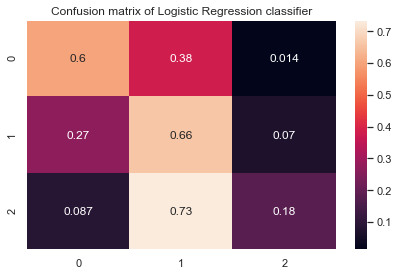

In [29]:
from sklearn.metrics import confusion_matrix,f1_score

# Calculate the accuracy of prediction
# Get the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(accuracy))

f1score = f1_score(y_test, y_pred, average='micro')
print('F1_Score: {:.4f}'.format(f1score))

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='.2g');
plt.title('Confusion matrix of Logistic Regression classifier')    
plt.tight_layout()

In [ ]:
import sys, os

summaryfile = 'ModelsFitness.txt'
nbdir = os.getcwd()
fsummary = open(f'{nbdir}\\{summaryfile}',"a") 
fsummary.write('Wine Quality Analysis with Logistic Regression\tProcessing (sec):{:.4f}\tAccuracy: {:.4f}\tF1-Score: {:.4f}\r\n'.format(proctime,accuracy,f1score))
fsummary.close() 